In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from tensorflow.keras import optimizers

In [2]:
root = r'C:\Users\janse\OneDrive\Bureaublad\Master\Data Mining Techniques'
dataset = root + r'\dataset_mood_smartphone.csv'
df_main = pd.read_csv(dataset)

In [3]:
# Extract daily features
df = df_main
variables = df.variable.unique()
df['time'] = pd.to_datetime(df['time'])
date_min = pd.to_datetime('2014-03-01')
df = df[df.time >= date_min]
df = pd.pivot_table(df, index=['id','time'], columns='variable', values='value').reset_index()
df['date'] = df['time'].apply(lambda x: x.date())
features = {'time':'count',
            'mood':'mean',
            'circumplex.valence':'mean',
            'circumplex.arousal' : 'mean',
            'activity':'mean',
            'screen':'sum',
            'call':'sum',
            'sms':'sum',
            'appCat.builtin': 'sum',
            'appCat.communication': 'sum',
            'appCat.entertainment': 'sum',
            'appCat.finance': 'sum',
            'appCat.game': 'sum',
            'appCat.office': 'sum',
            'appCat.other': 'sum',
            'appCat.social': 'sum',
            'appCat.travel': 'sum',
            'appCat.unknown': 'sum',
            'appCat.utilities': 'sum',
            'appCat.weather': 'sum'
           }
df = df.groupby(['id', 'date']).agg(features).reset_index()
df = df[~df.activity.isnull() & ~df.mood.isnull()]
# df = df[~((df.id == 'AS14.12') & (pd.to_datetime(df.date) == pd.to_datetime('2014-03-15')))]
# df[df.id == 'AS14.17'].head()

In [29]:
# Data quality
features = {'date':['min','max','count']}
df_quality = df.groupby('id').agg(features)
df_quality.columns = ["_".join(pair) for pair in df_quality.columns]
df_quality['days_between'] = (df_quality.date_max - df_quality.date_min).dt.days + 1
df_quality['days_missing'] = df_quality['days_between'] - df_quality['date_count']
df_quality

,date_min,date_max,date_count,days_between,days_missing
id,,,,,
AS14.01,2014-03-21,2014-05-04,45,45,0
AS14.02,2014-03-17,2014-04-24,36,39,3
AS14.03,2014-03-22,2014-05-07,46,47,1
AS14.05,2014-03-17,2014-05-05,50,50,0
AS14.06,2014-03-24,2014-05-08,45,46,1
AS14.07,2014-03-25,2014-05-04,41,41,0
AS14.08,2014-03-17,2014-05-05,50,50,0
AS14.09,2014-03-22,2014-04-26,36,36,0
AS14.12,2014-03-27,2014-05-05,40,40,0


In [21]:
# Clustering user types k=4

df_for_clustering = df.drop(['time', 'date'], axis=1)
features_mean = {'mood':'mean',
            'circumplex.valence':'mean',
            'circumplex.arousal' : 'mean',
            'activity':'mean',
            'screen':'mean',
            'call':'mean',
            'sms':'mean',
            'appCat.builtin': 'mean',
            'appCat.communication': 'mean',
            'appCat.entertainment': 'mean',
            'appCat.finance': 'mean',
            'appCat.game': 'mean',
            'appCat.office': 'mean',
            'appCat.other': 'mean',
            'appCat.social': 'mean',
            'appCat.travel': 'mean',
            'appCat.unknown': 'mean',
            'appCat.utilities': 'mean',
            'appCat.weather': 'mean'
           }
df_for_clustering = df_for_clustering.groupby('id').agg(features_mean)
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_for_clustering)
group = kmeans.predict(df_for_clustering)
user = df_for_clustering.reset_index()[['id']]
user['user_group'] = group

,id,group
0,AS14.01,1
1,AS14.02,2
2,AS14.03,2
3,AS14.05,2
4,AS14.06,3
5,AS14.07,3
6,AS14.08,0
7,AS14.09,2
8,AS14.12,3
9,AS14.13,3


In [4]:
# Preprocessing
window = 5

agg_dict = {'date':'count',
            'mood':['mean','first', 'last'],
            'circumplex.valence':'mean',
            'circumplex.arousal' : 'mean',
            'activity':'sum',
            'screen':'sum',
            'call':'sum',
            'sms':'sum',
            'appCat.builtin': 'sum',
            'appCat.communication': 'sum',
            'appCat.entertainment': 'sum',
            'appCat.finance': 'sum',
            'appCat.game': 'sum',
            'appCat.office': 'sum',
            'appCat.other': 'sum',
            'appCat.social': 'sum',
            'appCat.travel': 'sum',
            'appCat.unknown': 'sum',
            'appCat.utilities': 'sum',
            'appCat.weather': 'sum'
           }

def get_features(row, df, x, agg_dict):
    current_date = row['date']
    user_id = row['id']
    current_mood = row['mood']
    
    # get dataframe from previous x days
    last_window = df[(df.id == user_id) & (df.date >= current_date - pd.Timedelta(days=x)) & (df.date < current_date)]
    date_count = last_window.shape[0]
    
    last_window = last_window.groupby('id').agg(agg_dict).reset_index()
    
    # reset columns names
    last_window.columns = ["_".join(pair) for pair in last_window.columns]
    last_window['inactive_days'] = x - date_count
    last_window['label'] = current_mood
    
    return last_window

train_data = None

for i in range(df.shape[0]):
    row = df.iloc[i]
    temp = get_features(row, df, window, agg_dict)
    if i == 0:
        train_data = temp
    else:
        if i % 100 == 0:
            print('{} rows done'.format(i))
            
        train_data = pd.concat([train_data, temp])


100 rows done
200 rows done
300 rows done
400 rows done
500 rows done
600 rows done
700 rows done
800 rows done
900 rows done
1000 rows done
1100 rows done


In [66]:




labels = train_data['label'].values
features = train_data.drop(['label','id_'], axis=1).values

min_l = labels.min()
max_l = labels.max()

min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(features)
labels = min_max_scaler.fit_transform(labels.reshape(-1,1))

#labels = tf.keras.utils.normalize(labels)[0]

y_train, y_test, x_train, x_test = train_test_split(labels, features, train_size=0.9)



print(y_train.shape, y_test.shape, x_train.shape, x_test.shape)



learning_rates = [5e-5, 1e-5, 5e-6, 1e-6]
decays = [1e-6, 1e-7] 
epoch_amounts = [20, 30, 40] 
batch_sizes = [16]

results = []
counter = 0

for lr in learning_rates:
    for decay in decays:
        for epoch_amount in epoch_amounts:
            for batch_size in batch_sizes:
                
                if counter % 10 == 0:
                    print(counter)

                sgd = optimizers.SGD(lr=lr, momentum=0.8, decay=decay)

                model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(23, activation=tf.nn.relu),    
                    tf.keras.layers.Dense(100, activation=tf.nn.relu),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(100, activation=tf.nn.relu),
                    tf.keras.layers.Dense(1, activation='linear')
                ])

                model.compile(optimizer=sgd,
                              loss='mean_squared_error',
                              metrics=['mean_squared_error']
                             )

                model.fit(x_train, y_train, epochs=epoch_amount, batch_size=batch_size, verbose=0)
                evaluation = model.evaluate(x_test, y_test)


                predictions = np.array(model.predict(x_test))

                predictions = predictions * (max_l - min_l) + min_l
                values = y_test * (max_l - min_l) + min_l

                predictions = predictions.flatten()
                values = values.flatten()

                #predictions = pd.DataFrame({'value': predictions,'actual': values})
                settings = [lr, decay, epoch_amount]
                MSE = mean_squared_error(predictions, values)
                results.append([settings, MSE])
                
                counter += 1

(1010, 1) (113, 1) (1010, 23) (113, 23)
0
113/113 [==============================] - 1s 11ms/sample - loss: 0.1683 - mean_squared_error: 0.1683
10
113/113 [==============================] - 1s 12ms/sample - loss: 0.3932 - mean_squared_error: 0.3932
20
113/113 [==============================] - 1s 13ms/sample - loss: 0.2092 - mean_squared_error: 0.2092


In [67]:
results

[[[5e-05, 1e-06, 20], 0.514256623106956],
 [[5e-05, 1e-06, 30], 0.5178273321792368],
 [[5e-05, 1e-06, 40], 0.39555509203676026],
 [[5e-05, 1e-07, 20], 0.4560111453729931],
 [[5e-05, 1e-07, 30], 0.5665317010050669],
 [[5e-05, 1e-07, 40], 0.4575577537533124],
 [[1e-05, 1e-06, 20], 8.038990968318252],
 [[1e-05, 1e-06, 30], 3.7978408386974962],
 [[1e-05, 1e-06, 40], 0.8905269540736308],
 [[1e-05, 1e-07, 20], 6.750571026038815],
 [[1e-05, 1e-07, 30], 3.4224004939507338],
 [[1e-05, 1e-07, 40], 1.3783742737235918],
 [[5e-06, 1e-06, 20], 11.122177109440969],
 [[5e-06, 1e-06, 30], 5.413705232324928],
 [[5e-06, 1e-06, 40], 3.1282323601054283],
 [[5e-06, 1e-07, 20], 14.815454097852443],
 [[5e-06, 1e-07, 30], 10.368603176878551],
 [[5e-06, 1e-07, 40], 8.517759921540401],
 [[1e-06, 1e-06, 20], 16.551752759514514],
 [[1e-06, 1e-06, 30], 15.771638283988706],
 [[1e-06, 1e-06, 40], 7.859579476822507],
 [[1e-06, 1e-07, 20], 18.980886839559517],
 [[1e-06, 1e-07, 30], 18.825665095632296],
 [[1e-06, 1e-07,

In [20]:
labels = train_data['label'].values
features = train_data.drop(['label','id_'], axis=1).values

min_l = labels.min()
max_l = labels.max()

min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(features)
labels = min_max_scaler.fit_transform(labels.reshape(-1,1))

y_train, y_test, x_train, x_test = train_test_split(labels, features, train_size=0.9)

lr = 5e-05
decay = 1e-06
epoch_amount = 100
batch_size = 16
    
sgd = optimizers.SGD(lr=lr, momentum=0.8, decay=decay)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(250, activation=tf.nn.relu),    
    tf.keras.layers.Dense(150, activation=tf.nn.relu),
    tf.keras.layers.Dense(125, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=sgd,
              loss='mean_squared_error',
              metrics=['mean_squared_error']
             )

history = model.fit(x_train, y_train, epochs=epoch_amount, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test))
evaluation = model.evaluate(x_test, y_test)


predictions = np.array(model.predict(x_test))

predictions = predictions * (max_l - min_l) + min_l
values = y_test * (max_l - min_l) + min_l

predictions = predictions.flatten()
values = values.flatten()

#predictions = pd.DataFrame({'value': predictions,'actual': values})
settings = [lr, decay, epoch_amount]
MSE = mean_squared_error(predictions, values)
final_values = pd.DataFrame({'predicted':predictions,'actual':values})
print('MSE: {}'.format(MSE))
final_values.head()

113/113 [==============================] - 0s 185us/sample - loss: 0.0104 - mean_squared_error: 0.0104
MSE: 0.4191059202695766


,predicted,actual
0,7.112104,7.333333
1,7.323725,7.000000
2,6.895442,7.000000
3,6.586076,7.000000
4,6.813210,6.200000


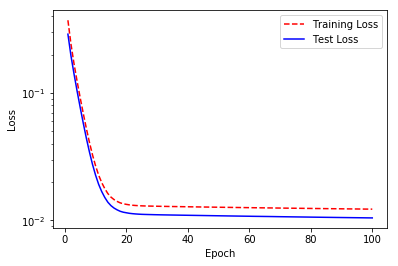

In [21]:

#print('Final LR: {}'.format(sess.run(sgd.lr)))
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()